# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

### Introduzione al Supervised Learning

In questa esercitazione faremo regressione su dati con rumore con Reti Neurali (*Neural Networks*, NNs). La regressione è uno dei tipici problemi del **Supervised Learning** in cui, partendo da dati di input già "etichettati", l'obiettivo è approssimare al meglio la funzione di *mapping* tra input ed output per predirre in modo corretto i *labels* (cioè gli output y) di nuovi dati di input x. Definiamo quindi le grandezze principali che caratterizzano un problema di *Supervised Learning*:

- Il **dataset** $D(X;Y)$ è l'insieme degli input X e degli output Y (labels);
- Il **modello** $f(X;p)$ è una funzione da X $\rightarrow$ Y dipendente da dei parametri p che serve a predire degli output dato un vettore di variabili di input;
- La **funzione costo** $C(Y;f(X;p))$ serve per valutare quanto bene il modello $f(X;p)$ approssima le osservazioni Y, cioè gli output attesi. Il modello viene quindi fittato per trovare i parametri p che minimizzano $C(Y;f(X;p))$.

Ciò che si fa è quindi per prima cosa dividere in modo casuale il dataset in 2 gruppi mutuamente esclusivi, il $D_{train}$ e il $D_{test}$, normalmente costituiti da ~90% e ~10% dei dati del dataset rispettivamente. I parametri migliori sono quindi ottenuti *fittando* il modello per minimizzare la funzione costo usando soltanto i dati del set di training: $p = min_p{C[Y_{train};f(X_{train};p)]}$. La quantità $E_{in} = C[Y_{train};f(X_{train};p)]$ è detta errore di training, mentre $E_{out} = C[Y_{test};f(X_{test};p)]$ è detta errore di generalizzazione e serve per valutare le performances del modello e dell'ottimizzazione che stiamo facendo su un set di dati su cui non è stato allenato. 

### Reti Neurali Artificiali (NNs)
Le Reti Neurali sono una delle tecniche principali per il Supervised ML; normalmente si usano reti feed-forward (direzionali). Una rete è costituita da dei **layers** in cui il primo è detto input layer, l'ultimo output layer e quelli (1 o più) compresi tra di essi sono chiamati *hidden layers*. In ogni layer è presente un certo numero di **neuroni** artificiali. Ogni neurone ha un certo numero di input $x_i$ provenienti dai neuroni dei layers precedenti: se la combinazione lineare degli input, moltiplicati quindi per dei pesi $w_i$ che esprimono la loro importanza relativa, è maggiore di una certa soglia, il neurone viene attivato (in base alla funzione di attivazione $f(z)$ e trasmette un output al layer successivo:
$$ z = \sum_{j}{w_j x_j} > soglia \rightarrow f(z) \rightarrow \mathrm{output} = y$$

I layers normalmente utilizzati in un problema di regressione sono detti **densi**, ovvero layers in cui tutti i neuroni di un layer sono connessi a tutti i neuroni del layer successivo e del precedente.

Oltre a specificare il numero di layers e il numero di neuroni per layer, un modello è anche caratterizzato:

- dalla **funzione di attivazione** dei neuroni;
- dall' **ottimizzatore**, cioè l'algoritmo scelto per ottimizzare i pesi dei neuroni durante il processo di training;
- dalla **funzione di loss** che è la funzione da minimizzare nella fase di ottimizzazione;
- dalla **metrica**, ovvero un ulteriore funzione (opzionale) che valuta le performance del modello durante la fase di training.

Nei seguenti esercizi useremo come dataset $D(X;Y)$ dei dati generati a partire dalla funzione esatta $f(x)$: $$
    y_i= f(x_i) + \eta_i,
$$

dove $\eta_i$ è un rumore gaussiano tale che $\langle \eta_i \rangle=0;\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma$.

## Esercizio 11.1 - Fit lineare

In questo primo esercizio consideriamo il caso di una funzione lineare:
$$
f(x)= mx+b=2x+1
$$
Dalle x estratte casualmente con $x \in [-1,1]$, creiamo le y attraverso la funzione modello con del rumore gaussiano con deviazione standard $\sigma$. Utilizziamo un modello con 1 solo layer con 1 solo neurone con ottimizzatore **sgd** = stochastic gradient descent, funzione di loss 'mse' = mean squared error e metrica 'mse' e studiamo le sue performances al variare del numero di epoche $N_{\mathrm{epochs}}$, del numero di dati $N_{\mathrm{train}}$ e del rumore $\sigma$.


Definiamo i parametri della funzione lineare ideale che andremo poi a predire attraverso la regressione tramite la NN.

In [419]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

Ora generiamo i dati di input, che possono deviare dal comportamento ideale in base al rumore.

In [428]:
import numpy as np

# generate training inputs
np.random.seed(0)
n_train = 100
n_valid = int(n_train/10)
x_train = np.random.uniform(-1, 1, n_train)
x_valid = np.random.uniform(-1, 1, n_valid)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.3 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

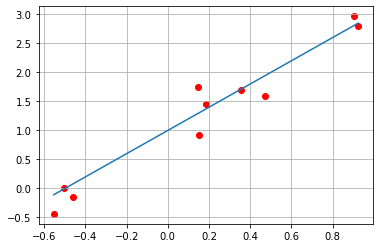

In [429]:
# plot training and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target)
plt.scatter(x_valid, y_valid, color='r')
plt.grid(True); plt.show()

In [430]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

In [431]:
# fit the model using training dataset
# over N epochs of 32 batch size each
# report training progress against validation data
n_epochs=100
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=n_epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 4.4943 - mse: 4.4943 - val_loss: 4.8436 - val_mse: 4.8436
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 4.2106 - mse: 4.2106 - val_loss: 4.5340 - val_mse: 4.5340
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 3.9742 - mse: 3.9742 - val_loss: 4.2330 - val_mse: 4.2330
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 3.7429 - mse: 3.7429 - val_loss: 4.0293 - val_mse: 4.0293
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 3.5585 - mse: 3.5585 - val_loss: 3.7296 - val_mse: 3.7296
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 3.3417 - mse: 3.3417 - val_loss: 3.5139 - val_mse: 3.5139
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 3.1720 - mse: 3.1720 - val_loss: 3.2721 - val_mse: 3.2721
Epoch 8/100
4/4 [==============================] - 0s 18ms/step - loss: 2.9919 - mse: 2.99

4/4 [==============================] - 0s 24ms/step - loss: 0.2269 - mse: 0.2269 - val_loss: 0.1829 - val_mse: 0.1829
Epoch 64/100
4/4 [==============================] - 0s 20ms/step - loss: 0.2207 - mse: 0.2207 - val_loss: 0.1773 - val_mse: 0.1773
Epoch 65/100
4/4 [==============================] - 0s 19ms/step - loss: 0.2147 - mse: 0.2147 - val_loss: 0.1724 - val_mse: 0.1724
Epoch 66/100
4/4 [==============================] - 0s 19ms/step - loss: 0.2092 - mse: 0.2092 - val_loss: 0.1662 - val_mse: 0.1662
Epoch 67/100
4/4 [==============================] - 0s 21ms/step - loss: 0.2021 - mse: 0.2021 - val_loss: 0.1612 - val_mse: 0.1612
Epoch 68/100
4/4 [==============================] - 0s 22ms/step - loss: 0.1966 - mse: 0.1966 - val_loss: 0.1568 - val_mse: 0.1568
Epoch 69/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1916 - mse: 0.1916 - val_loss: 0.1524 - val_mse: 0.1524
Epoch 70/100
4/4 [==============================] - 0s 25ms/step - loss: 0.1869 - mse: 0.1869 - 

In [432]:
# return weights
model.get_weights()

[array([[1.8290888]], dtype=float32), array([1.023928], dtype=float32)]

In [434]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 8ms/step - loss: 0.0865 - mse: 0.0865

Test loss: 0.08647019416093826
Test accuracy: 0.08647019416093826


In [435]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076

Test loss: 0.007633293978869915
Test accuracy: 0.007633293978869915


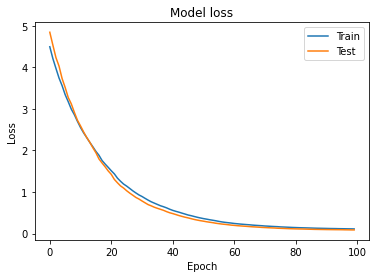

In [436]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

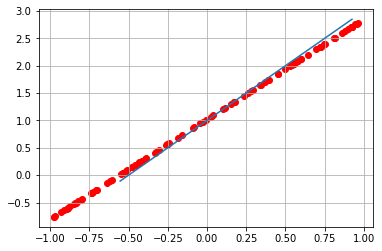

In [437]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

## 1 - Numero di dati $N_{train}$ "basso", $\sigma =0$, al variare del numero di epoche $N_{\mathrm{epochs}}$.
Per prima cosa, provo a vedere come il numero di epoche influisce sulle performances del modello nel caso di dati senza rumore. Faccio quindi girare il codice precedente più volte, tenendo fissato $N_{train}=100$ (e quindi $N_{test}=10$) e $\sigma=0$, provando per $N_{\mathrm{epochs}}=20,40,60,80,100$. 

$N_{train}$ | $N_{epochs}$ | $\sigma$ | m | b | loss
-----------|----------|------------|-----|-----|----
100|20|0|1.0286157|0.74572057|0.41560807824134827 
100|40|0|1.1836927|0.9225942|0.21777677536010742
100|60|0|1.5593163|0.95256734|0.0647784024477005
100|80|0|1.7403874|0.9799872|0.02143404446542263
100|100|0|1.9452381|0.9956775|0.0009563543135300279

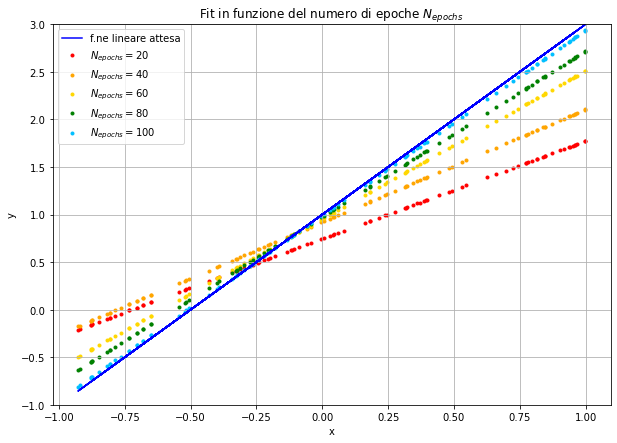

In [139]:
fig = plt.figure(figsize=(10,7))
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted_20 = 1.0286157*x_predicted + 0.74572057
y_predicted_40 = 1.1836927*x_predicted + 0.9225942
y_predicted_60 = 1.5593163*x_predicted + 0.95256734
y_predicted_80 = 1.7403874*x_predicted + 0.9799872
y_predicted_100 = 1.9452381*x_predicted + 0.9956775
plt.scatter(x_predicted, y_predicted_20,color='r', label = '$N_{epochs}=20$', marker = '.')
plt.scatter(x_predicted, y_predicted_40,color='orange', label = '$N_{epochs}=40$', marker = '.')
plt.scatter(x_predicted, y_predicted_60,color='gold', label = '$N_{epochs}=60$', marker = '.')
plt.scatter(x_predicted, y_predicted_80,color='green', label = '$N_{epochs}=80$', marker = '.')
plt.scatter(x_predicted, y_predicted_100,color='deepskyblue', label = '$N_{epochs}=100$', marker = '.')
plt.plot(x_predicted, m*x_predicted+b, color = 'blue', label='f.ne lineare attesa')
plt.grid(True)
plt.legend()
plt.title("Fit in funzione del numero di epoche $N_{epochs}$")
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1,3)
plt.show()

Come si può osservare dal grafico e dalla tabella, all'aumentare del numero di epoche (in ogni epoca uso tutti i dati di training diviso in un certo numero di batch) la rete riesce ad imparare meglio a fittare i dati anche usando un numero di dati di training basso come $N_{train}=100$. Se c'è la possibilità, è quindi meglio aumentare il numero di dati per facilitare il fit.

## 2 - Numero di dati $N_{train}$ "basso", $\sigma =0.2$, al variare del numero di epoche $N_{\mathrm{epochs}}$.
Ora provo a vedere come il numero di epoche influisce sulle performances del modello nel caso di dati con rumore $\sigma=0.2$. Faccio quindi girare il codice precedente più volte, tenendo fissato $N_{train}=100$ (e quindi $N_{test}=10$) e $\sigma=0.2$, provando per $N_{\mathrm{epochs}}=20,40,60,80,100$. 

$N_{train}$ | $N_{epochs}$ | $\sigma$ | m | b | loss $E_{out}$
-----------|----------|------------|-----|-----|----
100|20|0.2|0.7036623|0.7402779| 0.7061783075332642
100|40|0.2|1.08987|0.91263616| 0.3214171528816223
100|60|0.2|1.9254618|1.0105324|0.034842126071453094
100|80|0.2|1.9059215|1.0171925|0.036858703941106796
100|100|0.2|1.8567566|1.0162077|0.04134361818432808

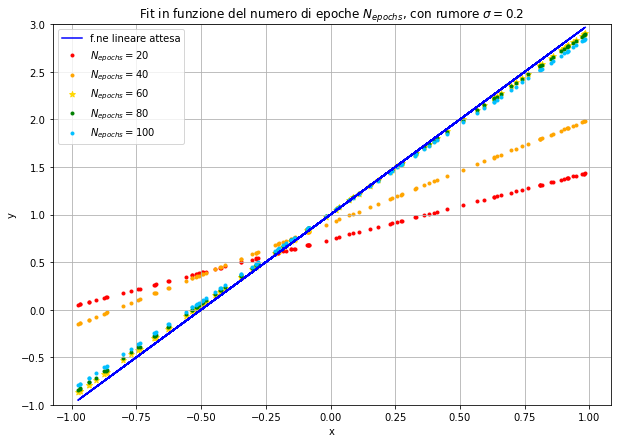

In [235]:
fig = plt.figure(figsize=(10,7))
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted_20 = 0.7036623*x_predicted + 0.7402779
y_predicted_40 = 1.08987*x_predicted + 0.91263616
y_predicted_60 = 1.9254618*x_predicted + 1.0105324
y_predicted_80 = 1.9059215*x_predicted + 1.0171925
y_predicted_100 = 1.8567566*x_predicted + 1.0162077
plt.scatter(x_predicted, y_predicted_20,color='r', label = '$N_{epochs}=20$', marker = '.')
plt.scatter(x_predicted, y_predicted_40,color='orange', label = '$N_{epochs}=40$', marker = '.')
plt.scatter(x_predicted, y_predicted_60,color='gold', label = '$N_{epochs}=60$', marker = '*')
plt.scatter(x_predicted, y_predicted_80,color='green', label = '$N_{epochs}=80$', marker = '.')
plt.scatter(x_predicted, y_predicted_100,color='deepskyblue', label = '$N_{epochs}=100$', marker = '.')
plt.plot(x_predicted, m*x_predicted+b, color = 'blue', label='f.ne lineare attesa')
plt.grid(True)
plt.legend()
plt.title("Fit in funzione del numero di epoche $N_{epochs}$, con rumore $\sigma=0.2$")
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1,3)
plt.show()

Come si può vedere dal grafico e dalla tabella, anche nel caso di dati con rumore si ha in generale un miglioramento del fit all'aumentare del numero di epoche $N_{epochs}$, ma non necessariamente al numero più alto di epoche corrisponde il fit migliore: infatti nell'esempio preso in considerazione, il fit più "vicino" alla funzione lineare target e con loss minore è quello con $N_{epochs}=60$ e non $N_{epochs}=100$ come ci si potrebbe invece aspettare.

## 3 - Numero di dati $N_{train}$ "più alto", $\sigma =0.0$, al variare del numero di epoche $N_{\mathrm{epochs}}$.
Ora provo a vedere come il numero di epoche influisce sulle performances del modello nel caso di un numero di dati più elevato $N_{train}=500,1000$ senza rumore. Faccio quindi girare il codice precedente più volte, tenendo fissato $N_{train}=500$ e poi $N_{train}=1000$ (e quindi $N_{test}=50$ e $N_{test}=100$ rispettivamente) e $\sigma=0.0$, provando per $N_{\mathrm{epochs}}=20,40,60,80,100$. 
### $N_{train}=500$

$N_{train}$ | $N_{epochs}$ | $\sigma$ | m | b | loss $E_{out}$
-----------|----------|------------|-----|-----|----
500|20|0.0|1.7463241|0.9957791| 0.006269928067922592
500|40|0.0|1.9807832|0.9998093| 0.00011745242227334529
500|60|0.0|1.999343|0.9999936|1.3728252667988272e-07
500|80|0.0|1.9996016|0.9999953|5.0455426503503986e-08
500|100|0.0|1.9999584|0.99999976|5.515055079285958e-10

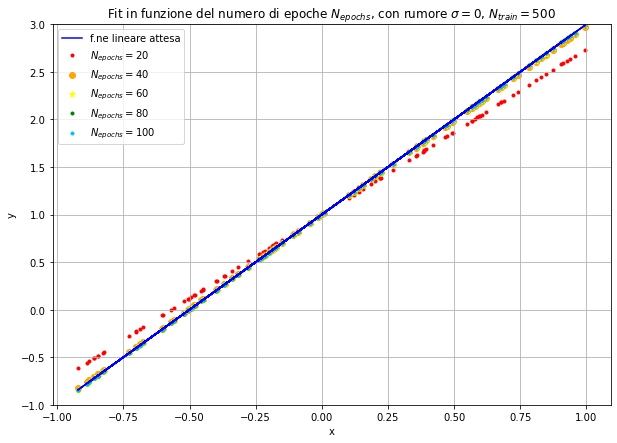

In [352]:
fig = plt.figure(figsize=(10,7))
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted_20 = 1.7463241*x_predicted + 0.9957791
y_predicted_40 = 1.9807832*x_predicted + 0.9998093
y_predicted_60 = 1.999343*x_predicted + 0.9999936
y_predicted_80 = 1.9996016*x_predicted + 0.9999953
y_predicted_100 = 1.9999584*x_predicted + 0.99999976
plt.scatter(x_predicted, y_predicted_20,color='r', label = '$N_{epochs}=20$', marker = '.')
plt.scatter(x_predicted, y_predicted_40,color='orange', label = '$N_{epochs}=40$')
plt.scatter(x_predicted, y_predicted_60,color='yellow', label = '$N_{epochs}=60$', marker = '*')
plt.scatter(x_predicted, y_predicted_80,color='green', label = '$N_{epochs}=80$', marker = '.')
plt.scatter(x_predicted, y_predicted_100,color='deepskyblue', label = '$N_{epochs}=100$', marker = '.')
plt.plot(x_predicted, m*x_predicted+b, color = 'blue', label='f.ne lineare attesa')
plt.grid(True)
plt.legend()
plt.title("Fit in funzione del numero di epoche $N_{epochs}$, con rumore $\sigma=0$, $N_{train}=500$")
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1,3)
plt.show()

Come si può osservare dal grafico, aumentando $N_{train}$ a 500 si ha un netto miglioramento del fit per ogni numero di epoche considerato rispetto a $N_{train}=100$.
### $N_{train}=1000$

$N_{train}$ | $N_{epochs}$ | $\sigma$ | m | b | loss $E_{out}$
-----------|----------|------------|-----|-----|----
1000|20|0.0|1.9656047|0.99976367| 0.00045833492185920477
1000|40|0.0|1.999843|0.9999986|9.547509449703284e-09
1000|60|0.0|1.999993|0.9999997|1.9129113223992356e-11

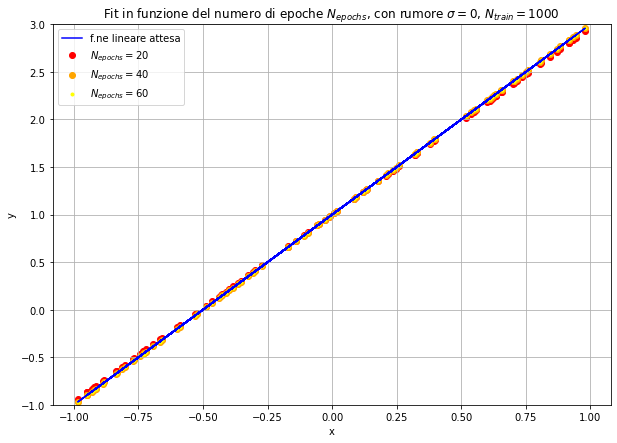

In [351]:
fig = plt.figure(figsize=(10,7))
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted_20 = 1.9656047*x_predicted + 0.99976367
y_predicted_40 = 1.999843*x_predicted + 0.9999986
y_predicted_60 = 1.999993*x_predicted + 0.9999997
plt.scatter(x_predicted, y_predicted_20,color='r', label = '$N_{epochs}=20$')
plt.scatter(x_predicted, y_predicted_40,color='orange', label = '$N_{epochs}=40$')
plt.scatter(x_predicted, y_predicted_60,color='yellow', label = '$N_{epochs}=60$', marker = '.')
plt.plot(x_predicted, m*x_predicted+b, color = 'blue', label='f.ne lineare attesa')
plt.grid(True)
plt.legend()
plt.title("Fit in funzione del numero di epoche $N_{epochs}$, con rumore $\sigma=0$, $N_{train}=1000$")
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1,3)
plt.show()

Aumentando ancora il numero di dati $N_{train}=1000$, si hanno ottimi risultati anche per un basso numero di epoche. Un modo quindi per ottenere buoni risultati è, quando possibile, usare un grande numero di dati di training.
## 4 - Numero di dati $N_{train}=100,500$ , al variare di $\sigma$
Possiamo infine considerare come il rumore sui dati influisca sulle performances del modello in due casi, con un numero di dati basso $N_{train}=100$ e uno più alto $N_{train}=500$. Faccio quindi girare il codice precedente più volte, tenendo fissato $N_{train}=100$ e poi $N_{train}=500$ (e quindi $N_{test}=10$ e $N_{test}=50$ rispettivamente) per $\sigma=0.0,0.1,0.2,0.3$, provando per $N_{\mathrm{epochs}}=100$ e $N_{\mathrm{epochs}}=40$ rispettivamente.

### $N_{train}=100$

$N_{train}$ | $N_{epochs}$ | $\sigma$ | m | b | loss $E_{out}$
-----------|----------|------------|-----|-----|----
100|100|0.0|1.9452381|0.9956775|0.0009563543135300279
100|100|0.1|1.7932202|0.99684113|0.023037508130073547
100|100|0.2|1.8619769|1.0082504|0.040275633335113525
100|100|0.3|1.8290888|1.023928|0.08647019416093826

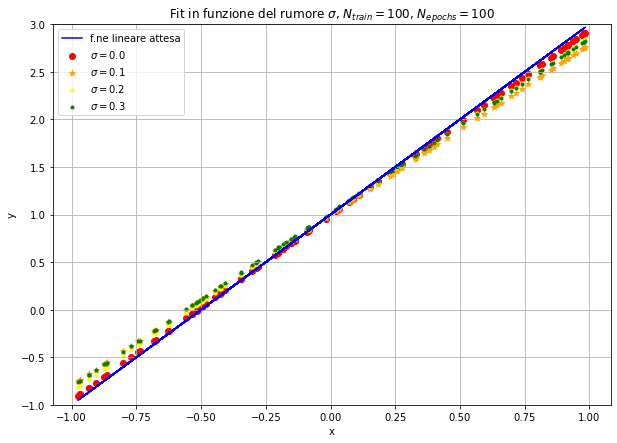

In [438]:
fig = plt.figure(figsize=(10,7))
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted_0 = 1.9452381*x_predicted + 0.9956775
y_predicted_01 = 1.7932202*x_predicted + 0.99684113
y_predicted_02 = 1.8619769*x_predicted + 1.0082504
y_predicted_03 = 1.8290888*x_predicted + 1.023928
plt.scatter(x_predicted, y_predicted_0,color='r', label = '$\sigma=0.0$')
plt.scatter(x_predicted, y_predicted_01,color='orange', label = '$\sigma=0.1$', marker = '*')
plt.scatter(x_predicted, y_predicted_02,color='yellow', label = '$\sigma=0.2$', marker = '.')
plt.scatter(x_predicted, y_predicted_03,color='green', label = '$\sigma=0.3$', marker = '.')
plt.plot(x_predicted, m*x_predicted+b, color = 'blue', label='f.ne lineare attesa')
plt.grid(True)
plt.legend()
plt.title("Fit in funzione del rumore $\sigma$, $N_{train}=100$, $N_{epochs}=100$")
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1,3)
plt.show()

### $N_{train}=500$

$N_{train}$ | $N_{epochs}$ | $\sigma$ | m | b | loss $E_{out}$
-----------|----------|------------|-----|-----|----
500|40|0.0|1.9807832|0.9998093| 0.00011745242227334529
500|40|0.1|2.0024712|0.9887484| 0.011156363412737846
500|40|0.2|1.9880093|0.97876465|0.04437663033604622
500|40|0.3|2.0004747|0.96687|0.1001824364066124

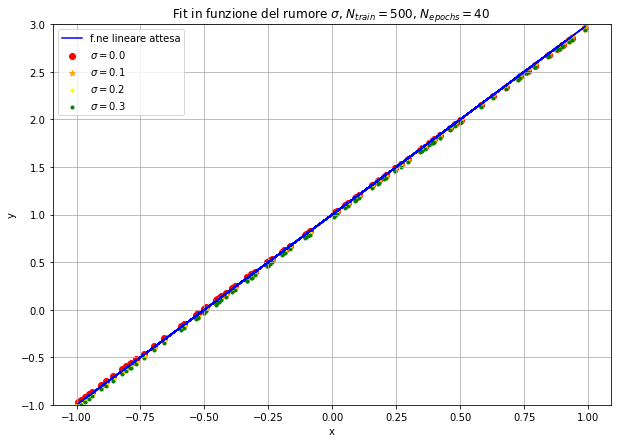

In [439]:
fig = plt.figure(figsize=(10,7))
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted_0 = 1.9807832*x_predicted + 0.9998093
y_predicted_01 = 2.0024712*x_predicted + 0.9887484
y_predicted_02 = 1.9880093*x_predicted + 0.97876465
y_predicted_03 = 2.0004747*x_predicted + 0.96687
plt.scatter(x_predicted, y_predicted_0,color='r', label = '$\sigma=0.0$')
plt.scatter(x_predicted, y_predicted_01,color='orange', label = '$\sigma=0.1$', marker = '*')
plt.scatter(x_predicted, y_predicted_02,color='yellow', label = '$\sigma=0.2$', marker = '.')
plt.scatter(x_predicted, y_predicted_03,color='green', label = '$\sigma=0.3$', marker = '.')
plt.plot(x_predicted, m*x_predicted+b, color = 'blue', label='f.ne lineare attesa')
plt.grid(True)
plt.legend()
plt.title("Fit in funzione del rumore $\sigma$, $N_{train}=500$, $N_{epochs}=40$")
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1,3)
plt.show()

Confrontando i due casi $N_{train}=100$ e $N_{train}=500$, si può vedere che all'aumentare del rumore, il caso con $N_{train}=500$ riesce sempre a dare i risultati migliori, considerando inoltre un numero di epoche minore rispetto a quello usato nel caso $N_{train}=100$ (40 epoche vs. 100 epoche). Ciò indica che, se possibile, è meglio aumentare il numero di dati di training piuttosto che il numero di epoche.